# Required assignment 12.1: Evaluating acquisition functions

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm


## Introduction

This notebook builds on your earlier work with Bayesian optimisation and surrogate models to focus on a key idea: how acquisition functions guide the search for optimal solutions in costly black-box problems. Rather than optimising the true objective directly, the optimiser targets an acquisition function, which is a faster proxy objective that balances exploration and exploitation. These functions use predictions from a surrogate model, such as a Gaussian process (GP), to decide where to sample next.

In this notebook, you’ll investigate popular acquisition functions, including probability of Iiprovement (PI), expected improvement and upper confidence bound (UCB), and consider how their different behaviours affect a model's performance.


## Acquisition functions

Once the surrogate model is in place, you can optimise an acquisition function to choose the next query point. This optimisation is typically done using gradient-based methods or numerical approaches such as Monte Carlo.

One simple yet effective option is the UCB acquisition function defined as:

$$
\alpha(x | D_n) = m_n(x) + \beta \cdot s_n(x)
$$

where $\beta$ is a parameter that controls the exploration – exploitation trade-off (higher $\beta$ means more exploration). You can then choose the next point using the following rule:

$$
x_{t+1} = \arg\max \alpha(x | D_t)
$$


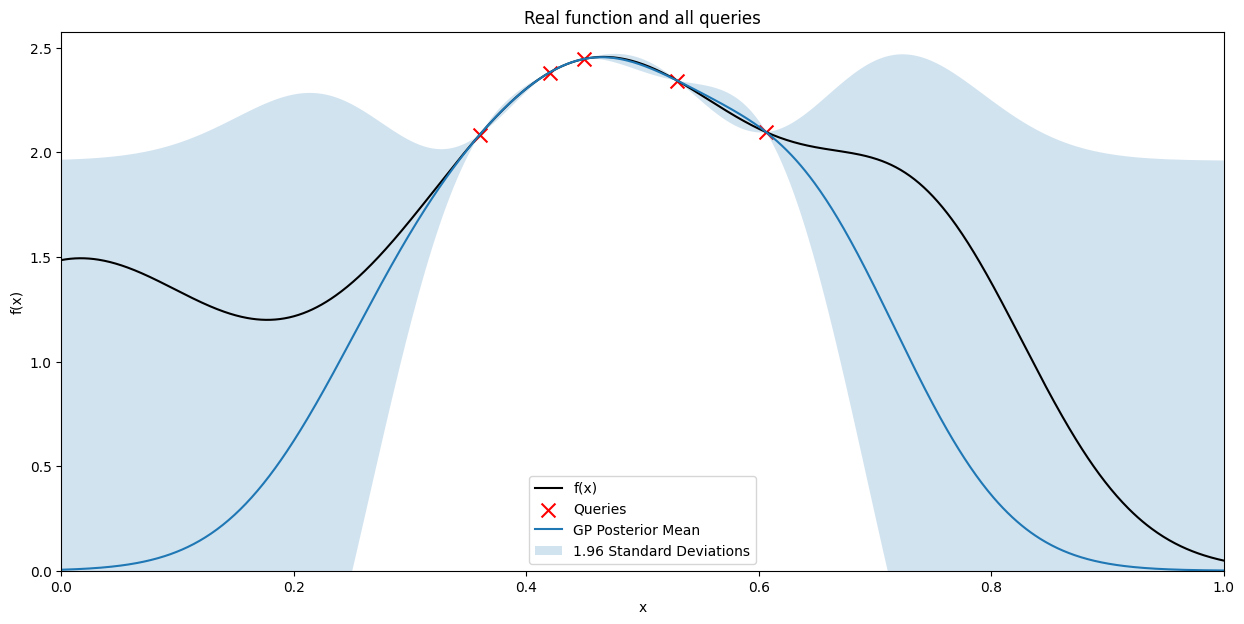

Maximum (by Grid-Search):
2.4560671656394737
UCB (Acquisition Function by Grid-Search):
2.446675372283102


In [10]:
real_noise_std = 1e-10
noise_assumption = 1e-10

rbf_lengthscale = 0.1

#Acquisition function parameter
beta = 1.96

#Draw random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low = 0.005, high = 0.05, size = modes)
means = np.random.uniform(size = modes)
amps = np.random.uniform(size = modes) * (2 - 1) + 1

#Define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)

#Define kernel of GP
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

#Define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)
#Initialise query lists and maximum observations
X, Y = [], []
max_obs = 0
#Initialise grid for plots
x_grid = np.linspace(0, 1, 101).reshape(-1, 1)

#Number of queries in the optimisation loop
num_queries = 5

for i in range(0, num_queries):
  #Clear the outputs to keep the interface clean
  clear_output(wait = True)
  model = GaussianProcessRegressor(kernel = kernel)
  #Fit the model
  if i != 0:
    model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
  #Calculate the mean and standard deviation and make them one-dimensional for plotting
  post_mean, post_std = model.predict(x_grid, return_std=True)
  post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

  #Initialise plots
  fig, ax = plt.subplots(figsize = (15, 7))
  #Set the x and y limits, labels and dynamic title
  ax.set_xlim(0, 1)
  ax.set_ylim(0, max(max_obs + 1, 3))
  ax.set_ylabel('f(x)')
  ax.set_xlabel('x')
  ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.' )
  #Plot queries
  ax.scatter(X, Y, c = 'r', marker='x', s = 100)
  #Plot the mean and standard deviation
  ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
  ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
  ax.legend()
  plt.show()
  #Initialise x
  x = -1
  #Select a display format for X and Y
  X_format =  ['%.2f' % query for query in X] #Two sig figs
  Y_format = ['%.4f' % obs for obs in Y] #Four sig figs

  data = [(query, obs) for query, obs in zip(X_format, Y_format)]
  print('Data so far (sorted by descending observations): ')
  print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start = 1))) #Display data
  _ = input('Input anything to see the next chosen point') #You are using this to allow the user to change plots


  acquisition_function = post_mean + beta * post_std

  if i == 0:
    x = np.random.uniform(0, 1) #The first observation is chosen randomly
  else:
    grid = x_grid.squeeze()
    x = grid[np.argmax(acquisition_function)] #Else use the acquisition function

  #Append data, calculate function and sort lists according to observation values
  X.append(x)
  y = calc_function(x) + np.random.normal(scale = real_noise_std)
  Y.append(y)
  X = [x for _, x in sorted(zip(Y, X), reverse = True)]
  Y.sort(reverse = True)
  max_obs = max(max_obs, y)

clear_output()

#Calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
  y = calc_function(x)
  y_real.append(y)
  best_obs_grid = max(best_obs_grid, y) #Keep track of the best observation


#Final GP posterior
model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
post_mean, post_std = model.predict(x_grid.reshape(-1, 1), return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()


#Final plot and display
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(x_grid, y_real, 'k', label = 'f(x)')
ax.scatter(X, Y, c = 'r', marker = 'x', label = 'Queries', s = 100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_ylim(bottom = 0)
ax.set_title('Real function and all queries')
ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
ax.legend()
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('UCB (Acquisition Function by Grid-Search):')
print(max_obs)

### Question 1

- Run and re-run the cell until the absolute difference between the true maximum (from grid search) and the best value from acquisition-selected points is **less than 0.01**.

- Capture a screenshot of the graph and submit it separately as your output.

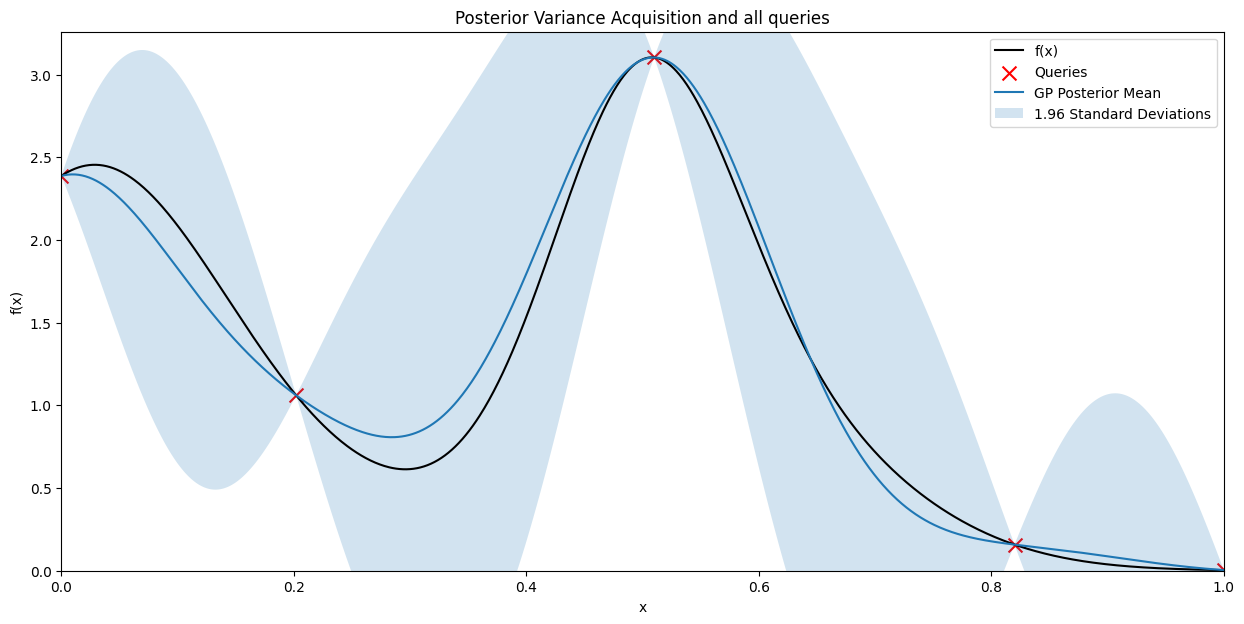

Maximum (by Grid-Search):
3.1041649805770417
Posterior Variance (Acquisition Function by Grid-Search):
3.103387802483603


In [11]:
#Parameters of the problem. Feel free to change them and play around with them.
real_noise_std = 1e-10  #Needs to be positive for code to work, instead of zero set 1e-10
noise_assumption = 1e-10

rbf_lengthscale = 0.1

#Acquisition function parameter (not used for variance-based acquisition)
beta = 1.96

#Draw random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low=0.005, high=0.05, size=modes)
means = np.random.uniform(size=modes)
amps = np.random.uniform(size=modes) * (2 - 1) + 1

#Define function
def calc_function(x):
    exp = -(x - means) ** 2 / std
    y = amps * np.exp(exp)
    return np.sum(y)

#Define the kernel of the GP
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
model = GaussianProcessRegressor(kernel=kernel, alpha=noise_assumption)

#Initialise query lists and maximum observations
X, Y = [], []
max_obs = 0
#Initialise grid for plots
x_grid = np.linspace(0, 1, 101).reshape(-1, 1)

#Number of queries in the optimisation loop
num_queries = 5

for i in range(0, num_queries):
    #Clear the outputs to keep the interface clean
    clear_output(wait=True)
    model = GaussianProcessRegressor(kernel=kernel)
    #Fit the model
    if i != 0:
        model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
    #Calculate the mean and standard deviation and make them one-dimensional for plotting
    post_mean, post_std = model.predict(x_grid, return_std=True)
    post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

    #Initialise plots
    fig, ax = plt.subplots(figsize=(15, 7))
    #Set the x and y limits, labels and dynamic title
    ax.set_xlim(0, 1)
    ax.set_ylim(0, max(max_obs + 1, 3))
    ax.set_ylabel('f(x)')
    ax.set_xlabel('x')
    ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.')
    #Plot queries
    ax.scatter(X, Y, c='r', marker='x', s=100)
    #Plot the mean and standard deviation
    ax.plot(x_grid.squeeze(), post_mean, label='GP Posterior Mean')
    ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha=0.2, label=str(beta) + ' Standard Deviations')
    ax.legend()
    plt.show()
    #Initialise x
    x = -1
    #Select a display format for X and Y
    X_format = ['%.2f' % query for query in X]  #Two sig figs
    Y_format = ['%.4f' % obs for obs in Y]      #Four sig figs

    data = [(query, obs) for query, obs in zip(X_format, Y_format)]
    print('Data so far (sorted by descending observations): ')
    print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start=1)))  #Display data
    _ = input('Input anything to see the next chosen point')  #You are using this to allow the user to change plots


    acquisition_function = post_std ** 2  #Variance-based acquisition


    if i == 0:
        x = np.random.uniform(0, 1)  #The first observation is chosen randomly
    else:
        grid = x_grid.squeeze()
        x = grid[np.argmax(acquisition_function)]  #Else use the acquisition function

    #Append data, calculate function and sort lists according to observation values
    X.append(x)
    y = calc_function(x) + np.random.normal(scale=real_noise_std)
    Y.append(y)
    X = [x for _, x in sorted(zip(Y, X), reverse=True)]
    Y.sort(reverse=True)
    max_obs = max(max_obs, y)

clear_output()

#Calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
    y = calc_function(x)
    y_real.append(y)
    best_obs_grid = max(best_obs_grid, y)  #Keep track of the best observation

#Final GP posterior
model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
post_mean, post_std = model.predict(x_grid.reshape(-1, 1), return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

#Final plot and display
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(x_grid, y_real, 'k', label='f(x)')
ax.scatter(X, Y, c='r', marker='x', label='Queries', s=100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0)
ax.set_title('Posterior Variance Acquisition and all queries')
ax.plot(x_grid.squeeze(), post_mean, label='GP Posterior Mean')
ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha=0.2, label=str(beta) + ' Standard Deviations')
ax.legend()
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('Posterior Variance (Acquisition Function by Grid-Search):')
print(max_obs)


### Question 2

PI is an intuitive acquisition function defined as:

$$ \alpha(x)_{PI} = \mathbb{P}(f(x) > y_{max})$$

Here, $y_{max}$ is the best observed value so far.

Now, run and rerun the cell until the absolute difference between the true maximum(from grid search) and the best value from PI-selected points is  **less than 0.01**.

Then, capture a screenshot of this graph and upload it separately onto Canvas as your output.

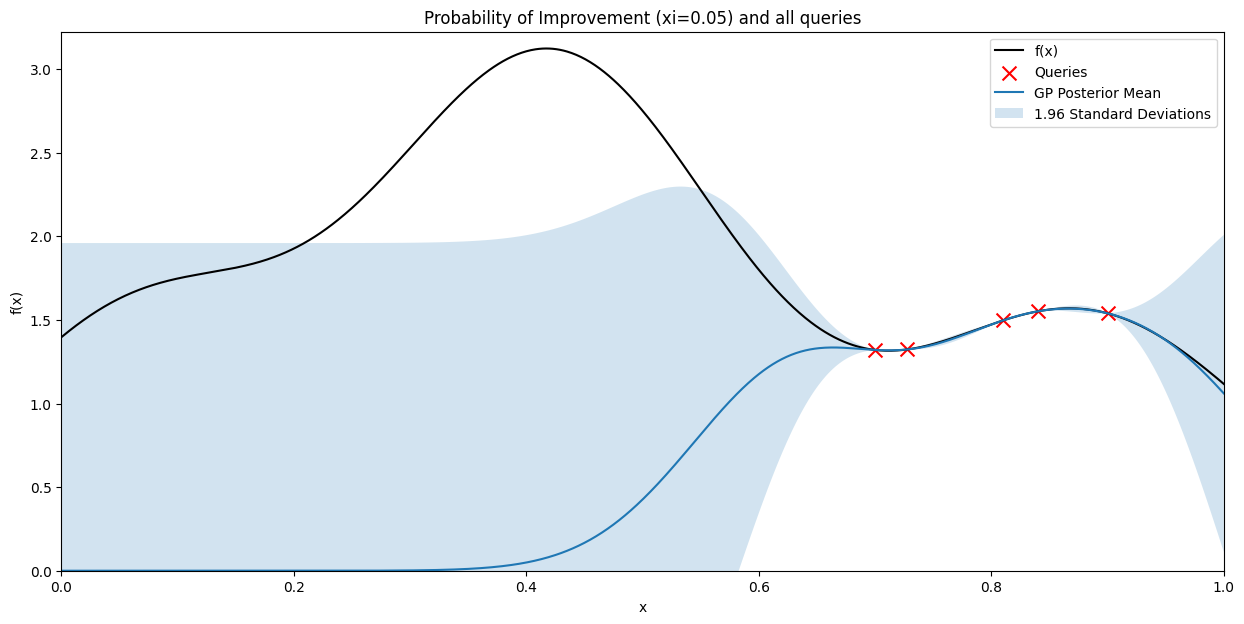

Maximum (by Grid-Search):
3.1238236240419543
Best Observation (by PI):
1.5516114362275681


In [15]:
###Parameters of the problem. Feel free to change them and play around with them.
real_noise_std = 1e-10  #Needs to be positive for code to work, instead of zero set 1e-10
noise_assumption = 1e-10

rbf_lengthscale = 0.1

#Acquisition function parameter (for PI, this is usually called xi)
xi = 0.05  #You can try 0.01 or 0.05 for more exploration

#Draw a random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low=0.005, high=0.05, size=modes)
means = np.random.uniform(size=modes)
amps = np.random.uniform(size=modes) * (2 - 1) + 1

#Define function
def calc_function(x):
    exp = -(x - means) ** 2 / std
    y = amps * np.exp(exp)
    return np.sum(y)

#Define the kernel of the GP
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
model = GaussianProcessRegressor(kernel=kernel, alpha=noise_assumption)

#Initialise query lists and maximum observations
X, Y = [], []
max_obs = 0

#Initialise grid for plots
x_grid = np.linspace(0, 1, 101).reshape(-1, 1)

#Number of queries in the optimisation loop
num_queries = 5

from scipy.stats import norm

for i in range(0, num_queries):
    #Clear the outputs to keep the interface clean
    clear_output(wait=True)
    model = GaussianProcessRegressor(kernel=kernel, alpha=noise_assumption)
    #Fit the model
    if i != 0:
        model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))


    #Calculate the mean and standard deviation and make them one-dimensional for plotting
    # Posterior predictions on grid
    post_mean, post_std = model.predict(x_grid, return_std=True)
    post_mean = post_mean.ravel()
    post_std  = post_std.ravel()

# ----- Q2: Probability of Improvement (PI) acquisition -----
    if i == 0:
        # No data yet: pick the first point at random (or center)
        acquisition_function = np.ones_like(post_mean)
        x_next = float(np.random.uniform(0, 1))
    else:
        f_best = np.max(Y)
        eps = 1e-12
        z = (post_mean - (f_best + xi)) / (post_std + eps)
        acquisition_function = norm.cdf(z)          # PI(x)
        x_next = float(x_grid[np.argmax(acquisition_function)])
# -----------------------------------------------------------


    #Initialise plots
    fig, ax = plt.subplots(figsize=(15, 7))
    #Set the x and y limits, labels and dynamic title
    ax.set_xlim(0, 1)
    ax.set_ylim(0, max(max_obs + 1, 3))
    ax.set_ylabel('f(x)')
    ax.set_xlabel('x')
    ax.set_title(f'So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.')
    #Plot queries
    ax.scatter(X, Y, c='r', marker='x', s=100)
    #Plot the mean and standard deviation
    ax.plot(x_grid.squeeze(), post_mean, label='GP Posterior Mean')
    ax.fill_between(x_grid.squeeze(), post_mean - 1.96*post_std, post_mean + 1.96*post_std, alpha=0.2, label='1.96 Standard Deviations')
    ax.legend()
    plt.show()

    #Initialise x
    x = -1
    #Select a display format for X and Y
    X_format = ['%.2f' % query for query in X]  #Two sig figs
    Y_format = ['%.4f' % obs for obs in Y]      #Four sig figs

    data = [(query, obs) for query, obs in zip(X_format, Y_format)]
    print('Data so far (sorted by descending observations): ')
    print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start=1)))  #Display data
    _ = input('Input anything to see the next chosen point')  #You are using this to allow the user to change plots


    if i == 0:
        acquisition_function = np.ones_like(post_mean)  #All probabilities are equal for the first point
    else:
        y_max = np.max(Y)
        with np.errstate(divide='warn'):
            z = (post_mean - y_max - xi) / (post_std + 1e-12)  #Add epsilon to avoid division by zero
            acquisition_function = norm.cdf(z)

    if i == 0:
        x = np.random.uniform(0, 1)  #The first observation is chosen randomly
    else:
        grid = x_grid.squeeze()
        x = grid[np.argmax(acquisition_function)]  #Else use the acquisition function

    #Append data, calculate function and sort lists according to observation values
    X.append(x)
    y = calc_function(x) + np.random.normal(scale=real_noise_std)
    Y.append(y)
    X = [x for _, x in sorted(zip(Y, X), reverse=True)]
    Y.sort(reverse=True)
    max_obs = max(max_obs, y)

clear_output()

#Calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
    y = calc_function(x)
    y_real.append(y)
    best_obs_grid = max(best_obs_grid, y)  #Keep track of the best observation

#Final GP posterior
model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
post_mean, post_std = model.predict(x_grid.reshape(-1, 1), return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

#Final plot and display
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(x_grid, y_real, 'k', label='f(x)')
ax.scatter(X, Y, c='r', marker='x', label='Queries', s=100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0)
ax.set_title(f'Probability of Improvement (xi={xi:.2f}) and all queries')
ax.plot(x_grid.squeeze(), post_mean, label='GP Posterior Mean')
ax.fill_between(x_grid.squeeze(), post_mean - 1.96*post_std, post_mean + 1.96*post_std, alpha=0.2, label='1.96 Standard Deviations')
ax.legend()
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('Best Observation (by PI):')
print(max_obs)


### Question 3

The PI acquisition function is highly exploitative. To encourage more exploration, you can add a small positive term:

$$ \alpha(x)_{\eta PI} = \mathbb{P}(x > y_{max} + \eta)$$

- Run and re-run the cell until the absolute difference between the true maximum(from grid search) and the best value from PI(with exploration term) is **less than 0.01**.

- Once this condition is met, capture a screenshot of the graph and upload it separately onto Canvas.

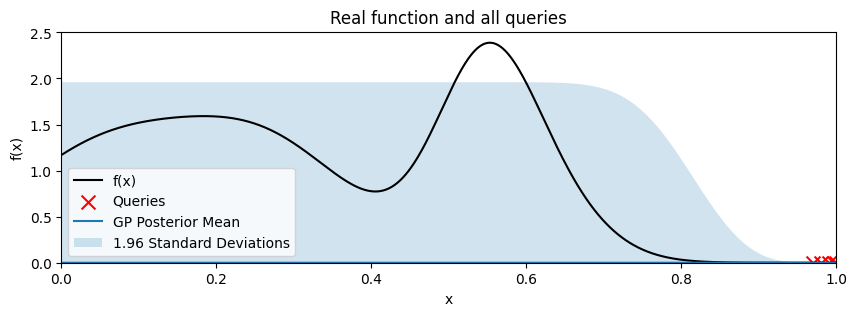

Maximum (by Grid-Search):
2.388335967713555
Best Observation (by PI):
1.3600910745974369e-05


In [16]:

#Parameters of the problem. Feel free to change them and play around with them.
real_noise_std = 1e-10  #Needs to be positive for code to work, instead of zero set 1e-10
noise_assumption = 1e-10

rbf_lengthscale = 0.1

#Acquisition function parameter (for PI, this is usually called xi)
xi = 0.3  #You can try 0.01 or 0.05 for more exploration
eta = 0.0
#Draw random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low=0.005, high=0.05, size=modes)
means = np.random.uniform(size=modes)
amps = np.random.uniform(size=modes) * (2 - 1) + 1

#Define function
def calc_function(x):
    exp = -(x - means) ** 2 / std
    y = amps * np.exp(exp)
    return np.sum(y)

#Define the kernel of the GP
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
model = GaussianProcessRegressor(kernel=kernel, alpha=noise_assumption)

#Initialise query lists and maximum observations
X, Y = [], []
max_obs = 0
#Initialise grid for plots
x_grid = np.linspace(0, 1, 101).reshape(-1, 1)

#Number of queries in the optimisation loop
num_queries = 5

for i in range(0, num_queries):
    #Clear the outputs to keep the interface clean
    clear_output(wait=True)
    model = GaussianProcessRegressor(kernel=kernel)
    #Fit the model
    if i != 0:
        model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
    #Calculate the mean and standard deviation and make them one-dimensional for plotting
    post_mean, post_std = model.predict(x_grid, return_std=True)
    post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

    #Initialise plots
    fig, ax = plt.subplots(figsize=(15, 7))
    #Set the x and y limits, labels and dynamic title
    ax.set_xlim(0, 1)
    ax.set_ylim(0, max(max_obs + 1, 3))
    ax.set_ylabel('f(x)')
    ax.set_xlabel('x')
    ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.')
    #Plot queries
    ax.scatter(X, Y, c='r', marker='x', s=100)
    #Plot the mean and standard deviation
    ax.plot(x_grid.squeeze(), post_mean, label='GP Posterior Mean')
    ax.fill_between(x_grid.squeeze(), post_mean - 1.96*post_std, post_mean + 1.96*post_std, alpha=0.2, label='1.96 Standard Deviations')
    ax.legend()
    plt.show()
    #Initialise x
    x = -1
    #Select a display format for X and Y
    X_format = ['%.2f' % query for query in X]  #Two sig figs
    Y_format = ['%.4f' % obs for obs in Y]      #Four sig figs

    data = [(query, obs) for query, obs in zip(X_format, Y_format)]
    print('Data so far (sorted by descending observations): ')
    print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start=1)))  #Display data
    _ = input('Input anything to see the next chosen point')  #You are using this to allow the user to change plots


    if i == 0:
        acquisition_function = np.ones_like(post_mean)  #All probabilities are equal for the first point
    else:
        y_max = np.max(Y)
        with np.errstate(divide='warn'):
            z = (post_mean - y_max - eta) / (post_std + 1e-12)  #Add epsilon to avoid division by zero
            acquisition_function = norm.cdf(z)

    if i == 0:
        x = np.random.uniform(0, 1)  #The first observation is chosen randomly
    else:
        grid = x_grid.squeeze()
        x = grid[np.argmax(acquisition_function)]  #Else use the acquisition function

    #Append data, calculate function and sort lists according to observation values
    X.append(x)
    y = calc_function(x) + np.random.normal(scale=real_noise_std)
    Y.append(y)
    X = [x for _, x in sorted(zip(Y, X), reverse=True)]
    Y.sort(reverse=True)
    max_obs = max(max_obs, y)

clear_output()

#Calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
    y = calc_function(x)
    y_real.append(y)
    best_obs_grid = max(best_obs_grid, y)  #Keep track of the best observation

#Final GP posterior
model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
post_mean, post_std = model.predict(x_grid.reshape(-1, 1), return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

#Final plot and display
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(x_grid, y_real, 'k', label='f(x)')
ax.scatter(X, Y, c='r', marker='x', label='Queries', s=100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0)
ax.set_title('Real function and all queries')
ax.plot(x_grid.squeeze(), post_mean, label='GP Posterior Mean')
ax.fill_between(x_grid.squeeze(), post_mean - 1.96*post_std, post_mean + 1.96*post_std, alpha=0.2, label='1.96 Standard Deviations')
ax.legend()
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('Best Observation (by PI):')
print(max_obs)
